# Neural Style Transfer + Color transfer

Algorithm based on Gatys et al. paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

## Imports

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.optim as optim
from torchvision import models, transforms
from matplotlib.gridspec import GridSpec

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Loading VGG19 model

In [4]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 57.5MB/s]


In [ ]:
# Put the model in GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg.to(device)

### Defining functions to use in gatys algorithm

In [28]:
# Load the image and convert it to a tensor

def load_image(img, max_size=400, shape=None):
    image = Image.fromarray(img)

    if max(image.size) > max_size:
        size = max_size
    else:
        size = min(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size), #resizes min size (w or h) keeping aspect ratio
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))]) #normalized with ImageNet mean and std

    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image

In [29]:
# Function to convert tensor to image

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

# Color transfer method

## Selecting images to import: content, style, color

In [20]:
name_content = "montblanc"
name_style = "ernst - max-ernst_1891/ernst_4"
name_color = "chagall - marc-chagall_1887/chagall_8"

In [21]:
content_url = "content_images/"+name_content+".jpg"
style_url = "bd-peintres/"+name_style+".jpg"
color_url = "bd-peintres/"+name_color+".jpg"

In [24]:
def compute_statistics(image):
    """ Compute the mean and covariance of the RGB channels. """
    reshaped_image = image.reshape(-1, 3)
    mean = np.mean(reshaped_image, axis=0)
    covariance = np.cov(reshaped_image, rowvar=False)
    return mean, covariance


def color_transfer(style_image, content_image, space='RGB'):
    # Convert images from RGB to LAB

    if space == 'LAB':
        style = cv2.cvtColor(style_image, cv2.COLOR_RGB2LAB)
        content = cv2.cvtColor(content_image, cv2.COLOR_RGB2LAB)
    if space == 'HSV':
        style = cv2.cvtColor(style_image, cv2.COLOR_RGB2HSV)
        content = cv2.cvtColor(content_image, cv2.COLOR_RGB2HSV)
    else:
        style = style_image
        content = content_image

    # Calculate means and covariances for style and content images in RGB
    mu_s, sigma_s = compute_statistics(style)
    mu_c, sigma_c = compute_statistics(content)

    # Perform Cholesky decomposition on content covariance matrix
    chol_c = np.linalg.cholesky(sigma_c)
    eigenvalues, eigenvectors = np.linalg.eigh(sigma_s)
    sigma_s_half = eigenvectors @ np.diag(np.sqrt(eigenvalues)) @ eigenvectors.T
    A = chol_c @ np.linalg.inv(sigma_s_half)

    # Calculate the translation vector b
    b = mu_c - A @ mu_s

    # Apply the transformation to each pixel
    transformed = (style.reshape(-1, 3) @ A.T + b).clip(0, 255).astype(np.uint8)
    transformed = transformed.reshape(style.shape)

    # Convert transformed RGB back to RGB
    if space == 'LAB':
        transformed_image = cv2.cvtColor(transformed, cv2.COLOR_LAB2RGB)
    if space == 'HSV':
        transformed_image = cv2.cvtColor(transformed, cv2.COLOR_HSV2RGB)
    else:
        transformed_image = transformed

    return transformed_image

def plot_histogram(image, title, ax):
    """ Plot the histogram for each RGB channel. """
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        ax.plot(hist, color=color)
        #Legend of color
        ax.legend(['Red', 'Green', 'Blue'])
    ax.set_xlim([0, 256])
    ax.set_title(title)

#PLOT HISTOGRAMS IN HSV
def plot_histogram_hsv(image, title, ax):

    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    colors = ('h', 's', 'v')
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        ax.plot(hist, color=color)
        #Legend of color
        ax.legend(['Hue', 'Saturation', 'Value'])
    ax.set_xlim([0, 256])
    ax.set_title(title)

def load_and_transform_images(style_path, content_path, color_path=None, space = 'RGB'):
    # Load images
    style_image = cv2.imread(style_path)
    content_image = cv2.imread(content_path)

    if color_path is not None:
        color_image = cv2.imread(color_path)
        # Dummy transformation: convert style image color space as an example
        transformed_image = color_transfer(style_image, color_image, space)

        # Convert images to RGB for display and histogram calculation
        style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
        content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2RGB)
        color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

        transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)

        return style_image, content_image, transformed_image, color_image

    else :
        # Dummy transformation: convert style image color space as an example
        transformed_image = color_transfer(style_image, content_image, space)

        # Convert images to RGB for display and histogram calculation
        style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
        content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2RGB)

        transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)

        return style_image, content_image, transformed_image, None

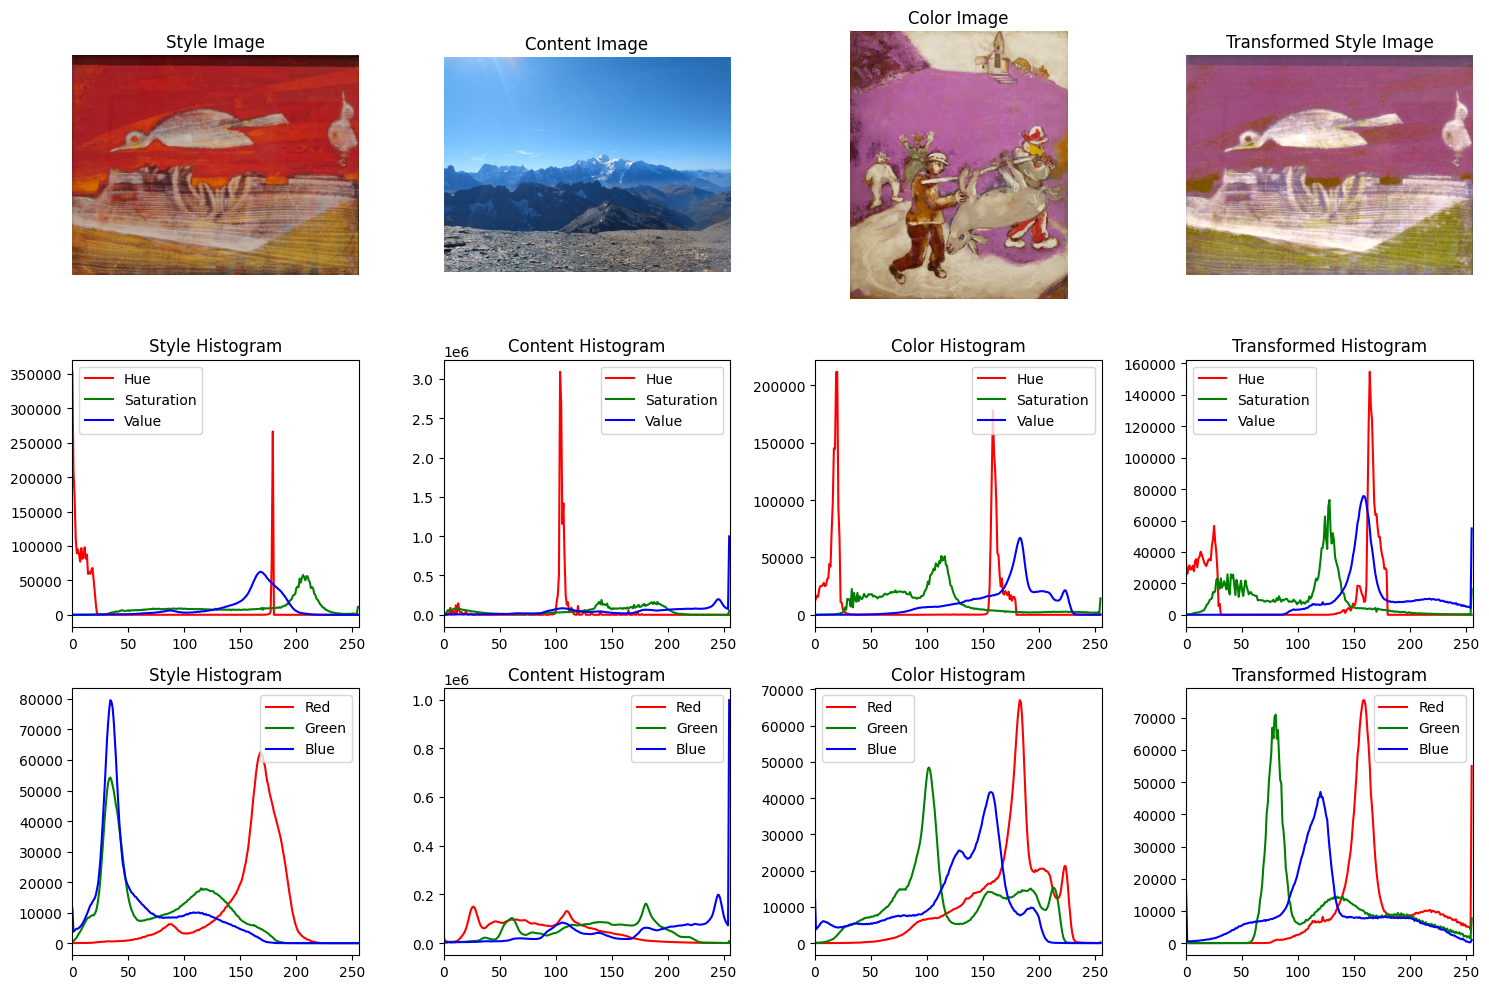

In [26]:
# Load and transform images
space = 'RGB'
style_image, content_image, transformed_image, color_image = load_and_transform_images(style_url, content_url, color_url, space)

fig, axs = plt.subplots(3, 4, figsize=(15, 10))

# Plot images
axs[0, 0].imshow(style_image)
axs[0, 0].set_title('Style Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(content_image)
axs[0, 1].set_title('Content Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(color_image)
axs[0, 2].set_title('Color Image')
axs[0, 2].axis('off')

axs[0, 3].imshow(transformed_image)
axs[0, 3].set_title('Transformed Style Image')
axs[0, 3].axis('off')


# Plot histograms
plot_histogram_hsv(style_image, 'Style Histogram', axs[1, 0])
plot_histogram_hsv(content_image, 'Content Histogram', axs[1, 1])
plot_histogram_hsv(color_image, 'Color Histogram', axs[1, 2])
plot_histogram_hsv(transformed_image, 'Transformed Histogram', axs[1, 3])


plot_histogram(style_image, 'Style Histogram', axs[2, 0])
plot_histogram(content_image, 'Content Histogram', axs[2, 1])
plot_histogram(color_image, 'Color Histogram', axs[2, 2])
plot_histogram(transformed_image, 'Transformed Histogram', axs[2, 3])

# Adjust layout
plt.tight_layout()
plt.show()


parts_style = name_style.split("/")
parts_color = name_color.split("/")

style_img = parts_style[-1]
color_img = parts_color[-1]

name_image = name_content + "_" + style_img + "_" + color_img + "_" + space + ".png"

fig.savefig(name_image)

### Quantitative analysis of color transferring

In [30]:
# loading images to test
content = load_image(content_image).to(device)
style = load_image(style_image, shape=content.shape[-2:]).to(device)
color = load_image(color_image, shape=content.shape[-2:]).to(device)
transformed = load_image(transformed_image, shape=content.shape[-2:]).to(device)

(-0.5, 532.5, 399.5, -0.5)

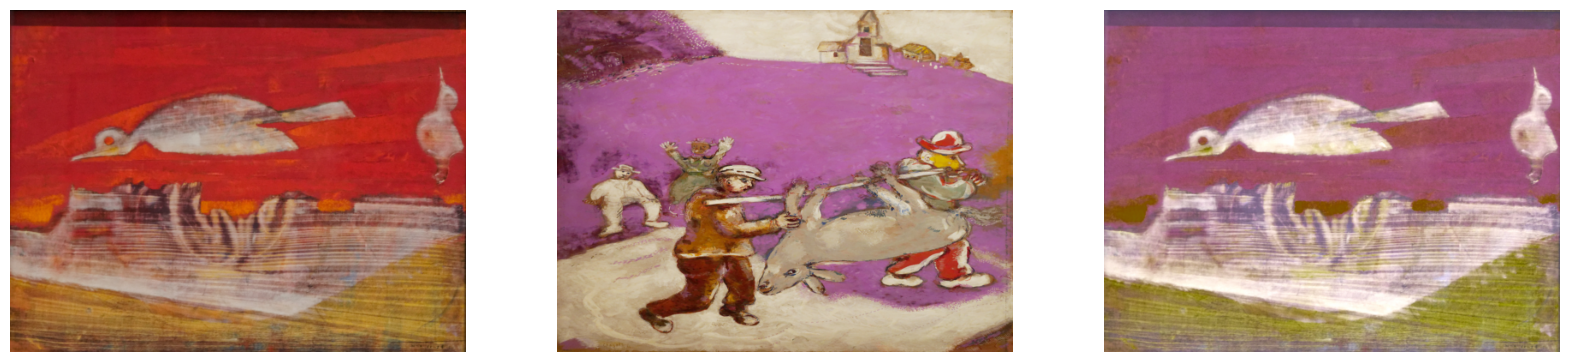

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.imshow(im_convert(style))
ax1.axis('off')
ax2.imshow(im_convert(color))
ax2.axis('off')
ax3.imshow(im_convert(transformed))
ax3.axis('off')

Chi-Squared result: 2231.3214153374533


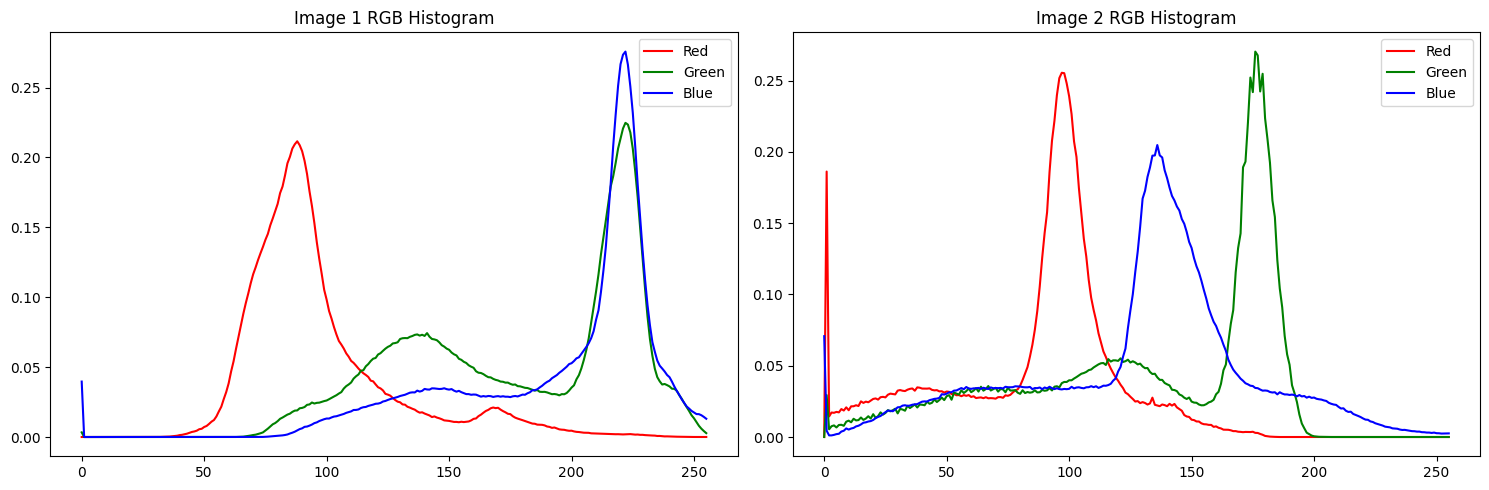

In [33]:
def calculate_rgb_histogram(image):
    # Calculate histograms for each channel
    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256])

    # Normalize the histograms
    hist_r = cv2.normalize(hist_r, hist_r).flatten()
    hist_g = cv2.normalize(hist_g, hist_g).flatten()
    hist_b = cv2.normalize(hist_b, hist_b).flatten()

    # stack the histograms
    hist_rgb = np.hstack((hist_r, hist_g, hist_b))

    return hist_rgb

def compare_histograms(hist1, hist2):
    # compare the two histograms using the chi-squared distance
    chi_squared = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    return chi_squared

hist1 = calculate_rgb_histogram((style_image*255).astype(np.uint8))
hist2 = calculate_rgb_histogram((transformed_image*255).astype(np.uint8))

# Compare histograms
chi_squared_result = compare_histograms(hist1, hist2)

print(f"Chi-Squared result: {chi_squared_result}")

# Plot the histograms
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram for image 1
axs[0].plot(hist1[:256], color='r', label='Red')
axs[0].plot(hist1[256:512], color='g', label='Green')
axs[0].plot(hist1[512:], color='b', label='Blue')
axs[0].set_title('Image 1 RGB Histogram')
axs[0].legend()

# Plot histogram for image 2
axs[1].plot(hist2[:256], color='r', label='Red')
axs[1].plot(hist2[256:512], color='g', label='Green')
axs[1].plot(hist2[512:], color='b', label='Blue')
axs[1].set_title('Image 2 RGB Histogram')
axs[1].legend()

plt.tight_layout()
plt.show()

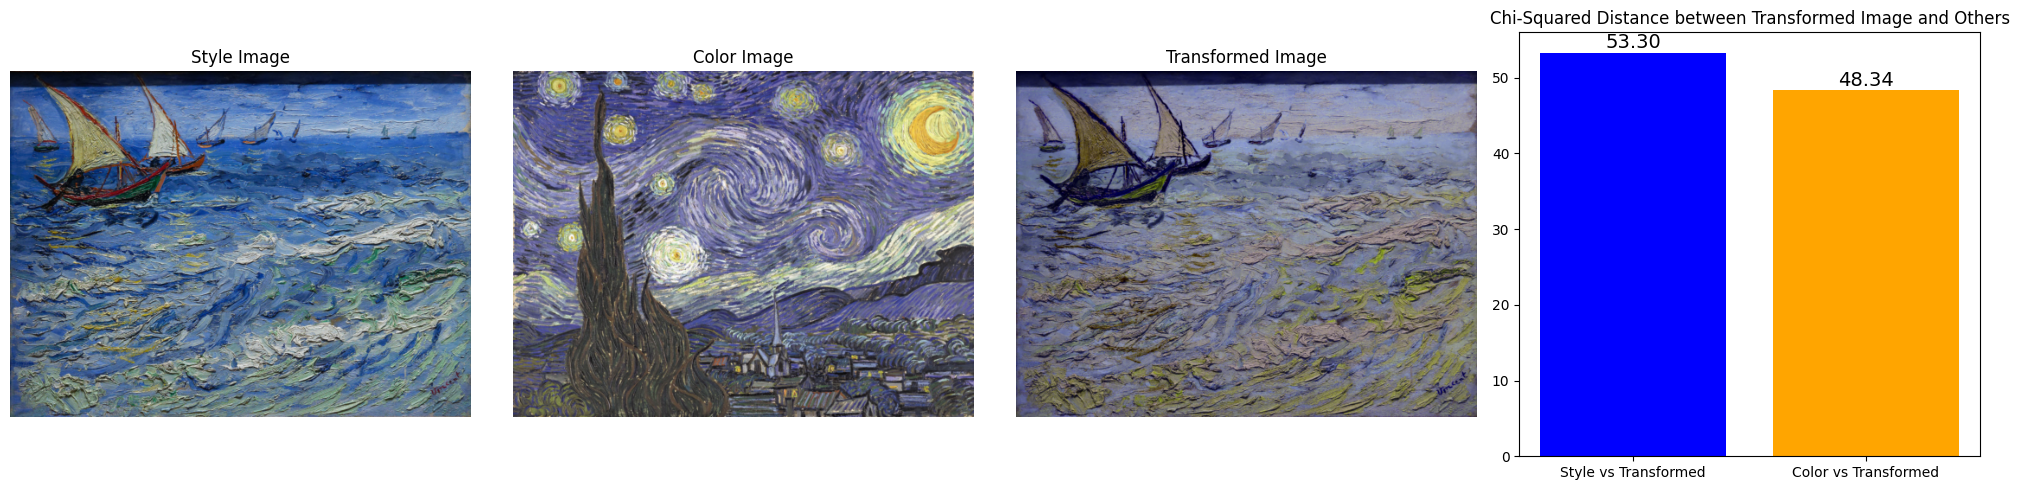

In [39]:
###### Plotting the chi-squared distance for different images

# Define the image names and URLs
name_content = "content_images/montblanc"
name_style = "bd-peintres/van-gogh - vincent-van-gogh_1853/van-gogh_3"
# name_style = "goya_3"
# name_color = "goya_4"
name_color = "bd-peintres/van-gogh - vincent-van-gogh_1853/van-gogh_24"

content_url = name_content + ".jpg"
style_url = name_style + ".jpg"
color_url = name_color + ".jpg"

# Load and transform images (assuming load_and_transform_images and load_image functions are defined)
style_image, content_image, transformed_image, color_image = load_and_transform_images(style_url, content_url, color_url, 'RGB')

style = load_image(style_image, shape=content.shape[-2:]).to(device)
color = load_image(color_image, shape=content.shape[-2:]).to(device)
transformed = load_image(transformed_image, shape=content.shape[-2:]).to(device)

# Convert tensors to images (assuming im_convert function is defined)
color_image = im_convert(color)
style_image = im_convert(style)
transformed_image = im_convert(transformed)

# Calculate histograms for style and transformed images (assuming calculate_rgb_histogram function is defined)
hist_style = calculate_rgb_histogram((style_image * 255).astype(np.uint8))
hist_transformed = calculate_rgb_histogram((transformed_image * 255).astype(np.uint8))

# Compare histograms (assuming compare_histograms function is defined)
chi_squared_style_transformed = compare_histograms(hist_style, hist_transformed)

# Calculate histogram for color image
hist_color = calculate_rgb_histogram((color_image * 255).astype(np.uint8))
chi_squared_color_transformed = compare_histograms(hist_color, hist_transformed)

# Create a figure with a specific size and GridSpec layout
fig = plt.figure(figsize=(20, 5))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 1])

# Plot the images
ax_style = plt.subplot(gs[0])
ax_style.imshow(style_image)
ax_style.set_title('Style Image')
ax_style.axis('off')

ax_color = plt.subplot(gs[1])
ax_color.imshow(color_image)
ax_color.set_title('Color Image')
ax_color.axis('off')

ax_transformed = plt.subplot(gs[2])
ax_transformed.imshow(transformed_image)
ax_transformed.set_title('Transformed Image')
ax_transformed.axis('off')

# Plot the histogram of Chi-Squared distances
ax_chart = plt.subplot(gs[3])

# Define the data
labels = ['Style vs Transformed', 'Color vs Transformed']
distances = [chi_squared_style_transformed, chi_squared_color_transformed]

# Plot the bar chart
ax_chart.bar(labels, distances, color=['blue', 'orange'])
ax_chart.set_title('Chi-Squared Distance between Transformed Image and Others')

# Display the values on top of the bars with increased font size
for i, v in enumerate(distances):
    ax_chart.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.show()

# Neural style transfer algorithm: complete pipeline

In [40]:
# func to compute gram matrix

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())

    return gram

In [41]:
# func to get the features from the VGG model

def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation layer
                  '28': 'conv5_1'}

    features = {}
    x = image
    for id, layer in model._modules.items():
        x = layer(x)
        if id in layers:
            features[layers[id]] = x
        #stop if the last conv layer is reached
        if id == '28':
            break

    return features

(-0.5, 1799.5, 1427.5, -0.5)

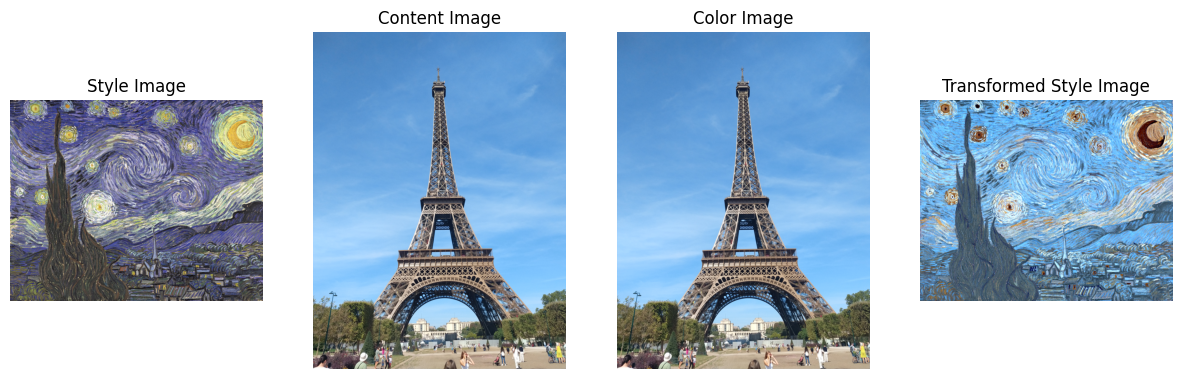

In [48]:
# Load and transform images
style_path = 'bd-peintres/van-gogh - vincent-van-gogh_1853/van-gogh_24.jpg'
content_path = 'content_images/paris.jpg'
color_path = 'content_images/paris.jpg'
style, content, transformed, color = load_and_transform_images(style_path, content_path, color_path, space='RGB')

fig, axs = plt.subplots(1, 4, figsize=(15, 10))

# Plot images
axs[0].imshow(style)
axs[0].set_title('Style Image')
axs[0].axis('off')

axs[1].imshow(content)
axs[1].set_title('Content Image')
axs[1].axis('off')

axs[2].imshow(color)
axs[2].set_title('Color Image')
axs[2].axis('off')

axs[3].imshow(transformed)
axs[3].set_title('Transformed Style Image')
axs[3].axis('off')

### Extracting features from content image and style/transformed image

In [50]:
content = load_image(content).to(device)
style = load_image(style, shape=content.shape[-2:]).to(device)
color = load_image(color, shape=content.shape[-2:]).to(device)
transformed = load_image(transformed, shape=content.shape[-2:]).to(device)

In [51]:
content_features = get_features(content, vgg)
#style_features = get_features(style, vgg)
style_features = get_features(transformed, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

### Defining weights and alpha-beta ratio for style loss

In [61]:
# style_weights = [
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 0.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.,'conv5_1': 0.2},
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.},

#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 1.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 1.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 1.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 1.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 1.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     ]


# style_weights = [
#     {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 1.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 1.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 0.,'conv3_1': 1.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 0.,'conv2_1': 1.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     {'conv1_1': 1.,'conv2_1': 0.,'conv3_1': 0.,'conv4_1': 0.,'conv5_1': 0.},
#     ]

style_weights = {'conv1_1': 1.,'conv2_1': 0.75,'conv3_1': 0.2,'conv4_1': 0.2,'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e8 # beta

### Optmization loop

Ratio:  1e-08
Total loss:  60646152.0
Total loss:  31719580.0
Total loss:  23351058.0
Total loss:  18370188.0
Total loss:  14851977.0


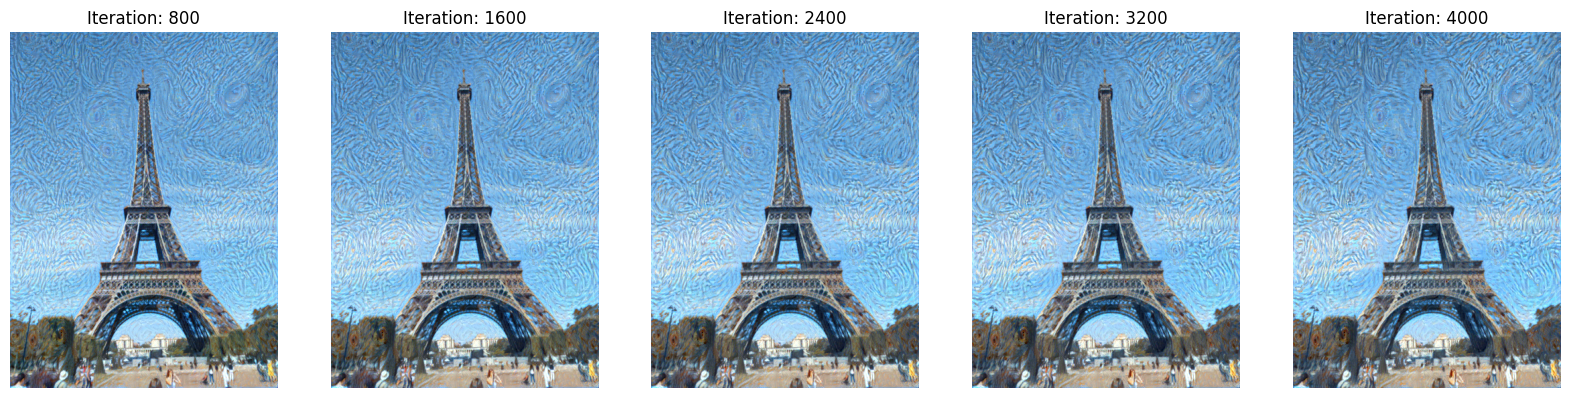

In [62]:
steps = 4000
learning_rate = 0.01
step_size = steps/5

images = []

print('Ratio: ', content_weight/style_weight)
image_target = {"beta": style_weight, "target": [], "iterations": []}

target = content.clone().requires_grad_(True).to(device)

optimizer = optim.Adam([target], lr=learning_rate)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

for i in range(1, steps+1):

    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    #scheduler.step()

    if  i % step_size == 0:
        print('Total loss: ', total_loss.item())
        #print last lr by   current scheduler
        #print('LR: ', scheduler.get_last_lr())
        image_target["target"].append(im_convert(target))
        image_target["iterations"].append(i)
        # plt.imshow(im_convert(target))
        # plt.axis('off')
        # plt.show()

        #Plot image result over iterations
    if i == steps:
        fig, axs = plt.subplots(1,int(len(image_target["target"])), figsize=(20, 10))

        for ax, image, iteration in zip(axs.flatten(), image_target["target"], image_target["iterations"]):
            ax.imshow(image)
            ax.set_title(f"Iteration: {iteration}")
            ax.axis('off')
        plt.show()

    # fig.suptitle(str(style_w))
    # plt.imshow(im_convert(target))
    # plt.axis('off')

    plt.show()


### Displaying results

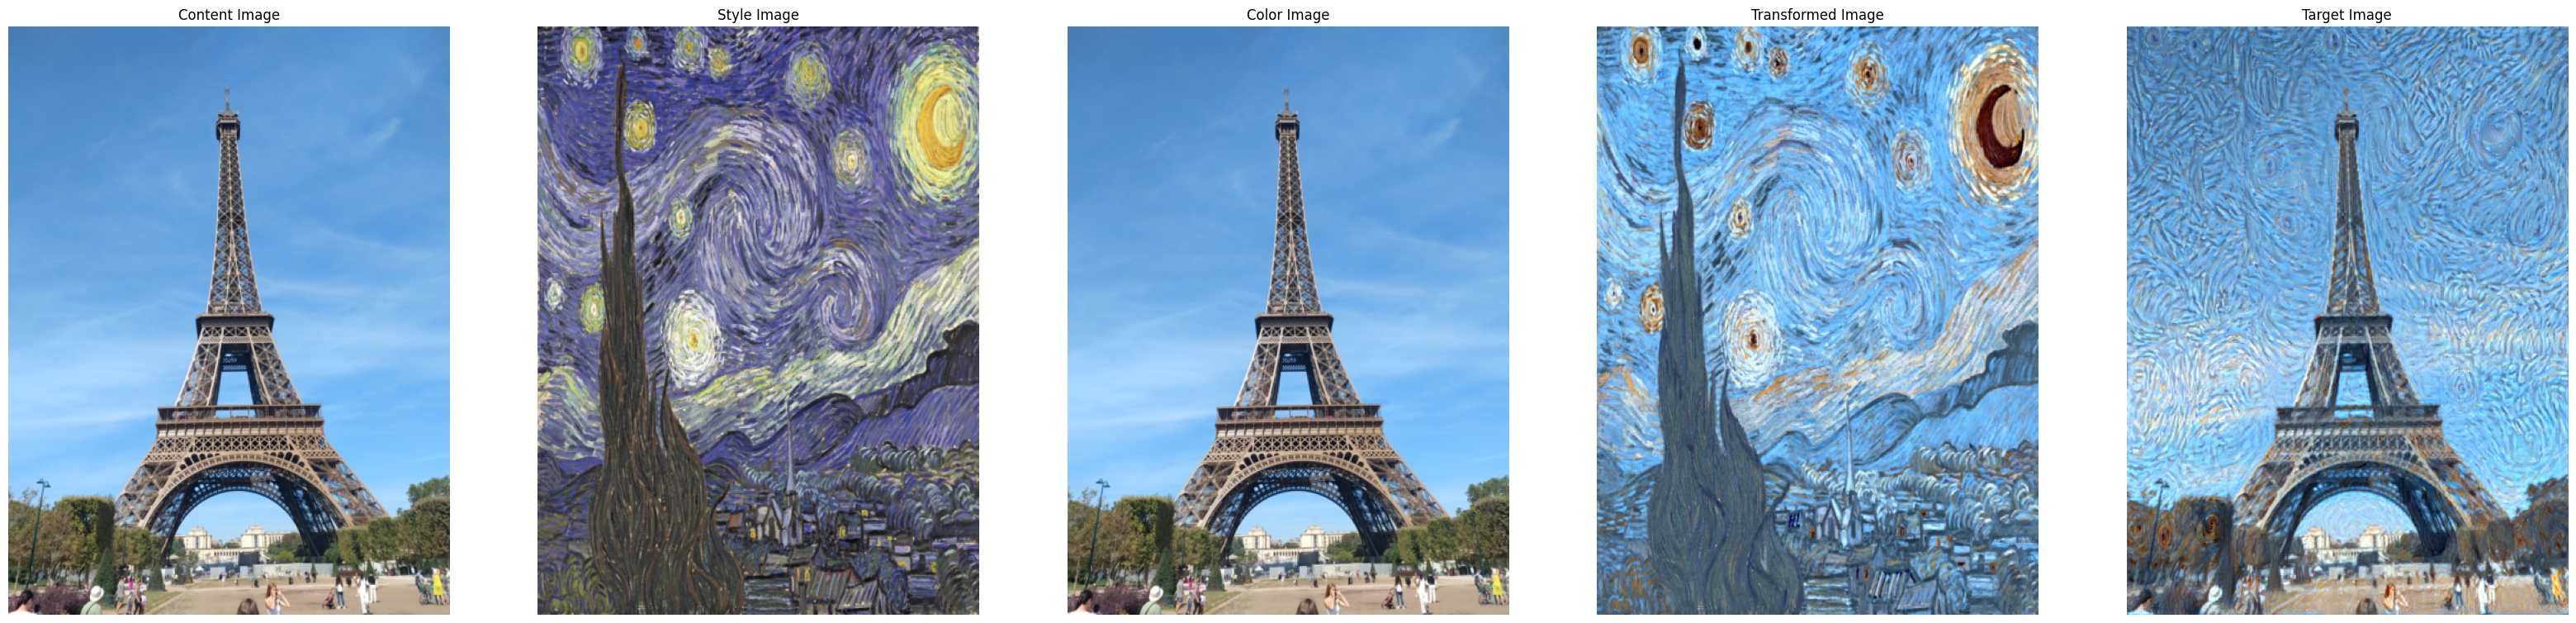

In [63]:
fig, (ax1, ax2, ax3,ax4, ax5) = plt.subplots(1, 5, figsize=(40, 20  ))
ax1.imshow(im_convert(content))
ax1.set_title('Content Image')
ax1.axis('off')

ax2.imshow(im_convert(style))
ax2.set_title('Style Image')
ax2.axis('off')

ax3.imshow(im_convert(color))
ax3.set_title('Color Image')
ax3.axis('off')

ax4.imshow(im_convert(transformed))
ax4.set_title('Transformed Image')
ax4.axis('off')

ax5.imshow(im_convert(target))
ax5.set_title('Target Image')
ax5.axis('off')

fig.savefig('results.png')